## Step 1: Load Libraries and Dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv("../data/log_sample.csv")
df.head()


,timestamp,src_ip,dst_ip,protocol,packet_count,byte_count,duration_sec,flags,label
0,2025-01-01 00:00:00,192.168.0.81,10.0.0.2,TCP,18,13548,0.56,FIN,benign
1,2025-01-01 00:01:00,192.168.0.115,10.0.0.32,ICMP,16,13599,0.49,PSH,DoS
2,2025-01-01 00:02:00,192.168.0.92,10.0.0.65,UDP,20,8186,6.40,SYN,DoS
3,2025-01-01 00:03:00,192.168.0.48,10.0.0.217,ICMP,16,5319,0.96,SYN,benign
4,2025-01-01 00:04:00,192.168.0.247,10.0.0.146,ICMP,17,4770,3.02,URG,benign


## Step 2: Data Preprocessing

In [5]:
df_encoded = df.copy()
le = LabelEncoder()
df_encoded['protocol'] = le.fit_transform(df_encoded['protocol'])
df_encoded['flags'] = le.fit_transform(df_encoded['flags'])
df_encoded['label'] = df_encoded['label'].map({'benign': 0, 'DoS': 1})
df_encoded = df_encoded.drop(columns=["timestamp", "src_ip", "dst_ip"])
df_encoded.head()


,protocol,packet_count,byte_count,duration_sec,flags,label
0,1,18,13548,0.56,1,0
1,0,16,13599,0.49,2,1
2,2,20,8186,6.40,4,1
3,0,16,5319,0.96,4,0
4,0,17,4770,3.02,5,0


## Step 3: Clustering (Optional)

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded.drop(columns=["label"]))

kmeans = KMeans(n_clusters=2, random_state=42)
df_encoded["cluster_kmeans"] = kmeans.fit_predict(X_scaled)

pd.crosstab(df_encoded['label'], df_encoded['cluster_kmeans'], rownames=['Actual'], colnames=['Cluster'])


Cluster,0,1
Actual,,
0,424,402
1,95,79


## Step 4: Balance Data with SMOTE

In [7]:
X = df_encoded.drop(columns=["label", "cluster_kmeans"])
y = df_encoded["label"]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


## Step 5: Train Random Forest Classifier

In [8]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))


Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.65      0.68       255
           1       0.66      0.73      0.69       241

    accuracy                           0.69       496
   macro avg       0.69      0.69      0.69       496
weighted avg       0.69      0.69      0.69       496

ROC AUC Score: 0.8023757220730616


## Step 6: ROC Curve and Confusion Matrix

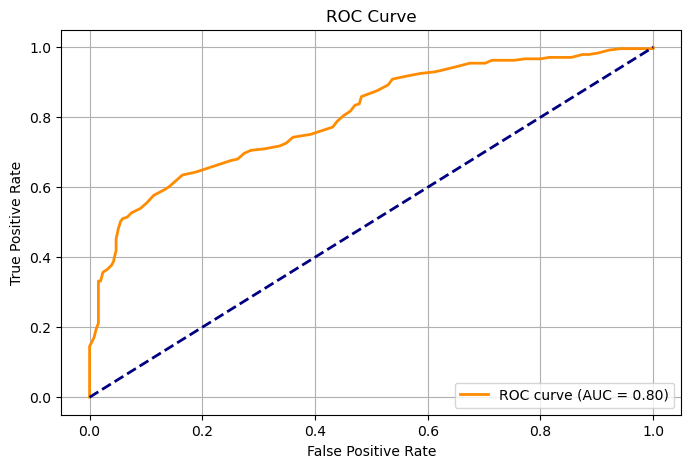

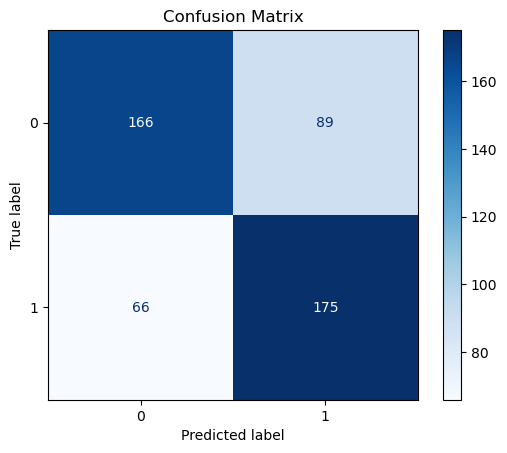

In [9]:
y_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()
